In [30]:
import polars as pl
import numpy as np
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

In [31]:
DATA_PATH = "data/20240717.csv"
META_PATH = "data/meta_20240717.csv"
IT_PATH = "data/IT"
IMAGE_PATH = "images"

In [32]:
if not os.path.exists(IT_PATH):
    os.makedirs(IT_PATH)
if not os.path.exists(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)

メタデータの取得

In [33]:
meta = pl.read_csv(META_PATH, has_header=False)
meta

column_1,column_2
str,f64
"""Sample Interval""",8.0000e-11
"""Record Length""",1250.0
"""Zero Index""",875.0
"""yOffset""",-0.036


In [34]:
record_len = int(meta.filter(pl.col("column_1") == "Record Length")[0,1])
record_len

1250

実データの分割

In [35]:
df_all = pl.read_csv(DATA_PATH)
df_all

TIME,CH1
f64,f64
-6.9995e-8,-0.00036
-6.9915e-8,6.9389e-18
-6.9835e-8,-0.00036
-6.9755e-8,6.9389e-18
-6.9675e-8,-0.00036
…,…
2.9660e-8,6.9389e-18
2.9740e-8,6.9389e-18
2.9820e-8,6.9389e-18


In [36]:
fastframe_count = df_all.shape[0] // record_len
fastframe_count

10000

In [37]:
mip_dfs = []
for i in range(fastframe_count):
    # DELAY_TIMEを引いておく
    mip_dfs.append(df_all[i*record_len:(i+1)*record_len])

In [38]:
mip_dfs[0].write_csv(f"{IT_PATH}/mip_0.csv")

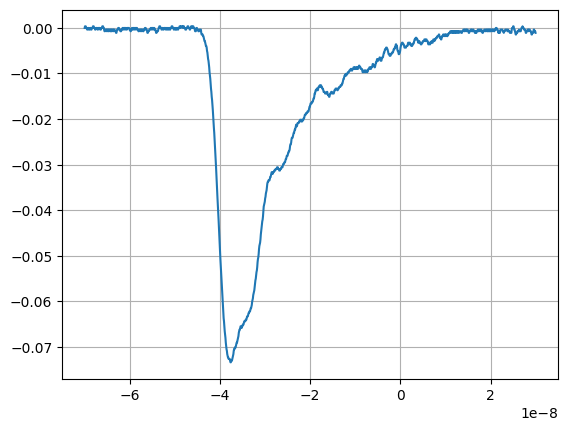

In [39]:
num = 1
fig, ax = plt.subplots()
ax.plot(mip_dfs[num]["TIME"], mip_dfs[num]["CH1"])
ax.grid()

フィッテング

In [40]:
def fitfunc(t, A, B, C, T):
    t = np.array(t)
    return np.where(t < T, C, -A*np.exp(-B*(t-T))+C)

In [41]:
def fiting(df: pl.DataFrame, f):
    maxfev = 1000000  # 最大反復回数を増やす
    time = df["TIME"].to_numpy()
    ch1 = df["CH1"].to_numpy()
    
    # NaNとinfを削除
    mask = ~np.isnan(time) & ~np.isnan(ch1) & ~np.isinf(time) & ~np.isinf(ch1)
    time = time[mask]
    ch1 = ch1[mask]
    
    # 初期パラメータの調整
    A_init = ch1.min()
    C_init = 0
    B_init = 1e8 # ここの値は微調整が必要   
    T_init = time[ch1.argmin()]
    init = [A_init, B_init, C_init, T_init]
    
    bounds = ([-1, 0, -1, time.min()], [np.inf, np.inf, 1, time.max()])
    
    try:
        popt, pcov = curve_fit(f, time, ch1, p0=init, bounds=bounds, maxfev=maxfev)
    except RuntimeError as e:
        print(f"Fit did not converge: {e}")
    return popt, pcov, mask

In [42]:
mip_popts = []
mip_pcovs = []
mip_masks = []

for i in range(fastframe_count):
    popt, pcov, mask = fiting(mip_dfs[i], fitfunc)
    mip_popts.append(popt)
    mip_pcovs.append(pcov)
    mip_masks.append(mask)
mip_popts

[array([ 4.91657031e-02,  7.12185568e+07, -3.23369163e-04, -4.14539262e-08]),
 array([ 8.32908914e-02,  7.01150763e+07, -2.37991293e-04, -4.06587424e-08]),
 array([ 4.16635825e-02,  6.99233399e+07, -3.54146904e-04, -4.15470294e-08]),
 array([ 4.66361616e-02,  7.23329276e+07, -3.14136211e-04, -4.10180481e-08]),
 array([ 4.17991889e-02,  7.42772470e+07, -1.59622960e-04, -4.10077686e-08]),
 array([ 9.72902721e-02,  7.20870471e+07, -6.87495937e-04, -4.02796258e-08]),
 array([ 4.89353647e-02,  8.87298026e+07, -5.89931048e-04, -4.14637114e-08]),
 array([ 8.43217746e-02,  6.99719629e+07,  2.26335629e-04, -4.06152448e-08]),
 array([ 5.37556840e-02,  8.10489911e+07, -5.89717891e-04, -4.12508725e-08]),
 array([ 3.68680979e-02,  7.04032547e+07, -3.76213926e-04, -4.05741376e-08]),
 array([ 4.95199551e-02,  7.80112079e+07, -8.97704180e-04, -4.05210257e-08]),
 array([ 5.61186154e-02,  7.22347078e+07, -3.83660866e-04, -4.02024338e-08]),
 array([ 4.50960425e-02,  8.09765871e+07, -7.39501907e-04, -4.14

In [43]:
def plot_waveform(df, ax):
    ax.plot(df["TIME"]*10**6, df["CH1"]*10**3)
    ax.set_xlabel(r"Time ($\mu $s)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()

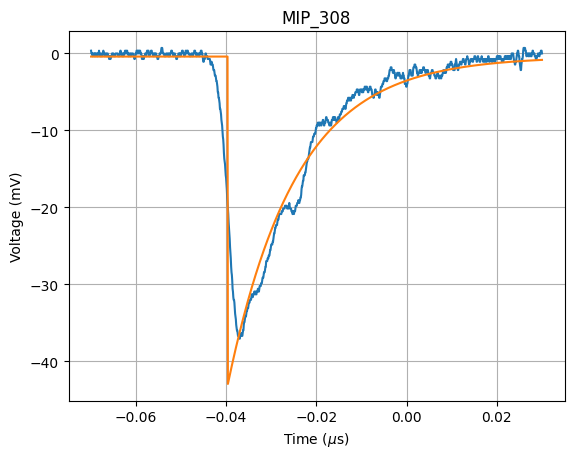

In [44]:
# ミューオンのフィッテング結果
num = 308

def plot_waveform(df, ax):
    ax.plot(df["TIME"]*10**6, df["CH1"]*10**3)
    ax.set_xlabel(r"Time ($\mu $s)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()

fig, ax = plt.subplots()
plot_waveform(mip_dfs[num], ax)
ax.plot(mip_dfs[num]["TIME"]*10**6, fitfunc(mip_dfs[num]["TIME"], *mip_popts[num])*10**3)
ax.set_title("MIP_{}".format(num))
fig.savefig(f"{IMAGE_PATH}/muon_fit_{num}.png")
plt.show()

面積（総電荷量）

In [65]:
bin_num = 100

In [66]:
def S(popt):
    A, B, _, _ = popt
    return A/B

def integrate_min_dfs(min_dfs: list):
    integrals = []
    for df in min_dfs:
        if df is not None:
            time = df['TIME'].to_numpy()
            ch1 = -df['CH1'].to_numpy()
            integral = np.trapezoid(ch1, time)
            integrals.append(integral)
    return integrals

In [67]:
mip_S = [S(popt) for popt in mip_popts]
mip_S

[np.float64(6.903496122480608e-10),
 np.float64(1.1879170041429718e-09),
 np.float64(5.958465727536898e-10),
 np.float64(6.447431768682522e-10),
 np.float64(5.627455318507341e-10),
 np.float64(1.349622102260759e-09),
 np.float64(5.515099015103468e-10),
 np.float64(1.2050794503625853e-09),
 np.float64(6.632492671185311e-10),
 np.float64(5.236703616345141e-10),
 np.float64(6.347800073995852e-10),
 np.float64(7.768926757701397e-10),
 np.float64(5.569022376672127e-10),
 np.float64(6.158480682443265e-10),
 np.float64(7.812732912269934e-10),
 np.float64(5.341093285487221e-10),
 np.float64(5.294840487149306e-10),
 np.float64(5.803263559199544e-10),
 np.float64(7.673211813483052e-10),
 np.float64(6.684526816249041e-10),
 np.float64(1.0550634168227153e-09),
 np.float64(5.95686710027509e-10),
 np.float64(7.521482500144434e-10),
 np.float64(6.055981387724408e-10),
 np.float64(5.619553711793649e-10),
 np.float64(1.1871494669314365e-09),
 np.float64(6.447605517380466e-10),
 np.float64(5.78427928158

In [68]:
int_mip_S = integrate_min_dfs(mip_dfs)
int_mip_S

[np.float64(7.109999999999999e-10),
 np.float64(1.1946383999999998e-09),
 np.float64(6.183504e-10),
 np.float64(6.564671999999998e-10),
 np.float64(5.699807999999999e-10),
 np.float64(1.396872e-09),
 np.float64(6.034175999999999e-10),
 np.float64(1.1614175999999998e-09),
 np.float64(7.188048e-10),
 np.float64(5.434559999999999e-10),
 np.float64(7.218863999999999e-10),
 np.float64(7.965503999999998e-10),
 np.float64(6.239664e-10),
 np.float64(6.220655999999999e-10),
 np.float64(8.162495999999999e-10),
 np.float64(5.694047999999999e-10),
 np.float64(5.674608e-10),
 np.float64(5.558111999999999e-10),
 np.float64(7.896239999999998e-10),
 np.float64(7.290431999999999e-10),
 np.float64(1.1003759999999998e-09),
 np.float64(6.235344e-10),
 np.float64(7.15752e-10),
 np.float64(6.612767999999999e-10),
 np.float64(5.959295999999998e-10),
 np.float64(1.1846735999999997e-09),
 np.float64(6.169535999999998e-10),
 np.float64(5.855039999999998e-10),
 np.float64(7.99056e-10),
 np.float64(6.865344e-10),

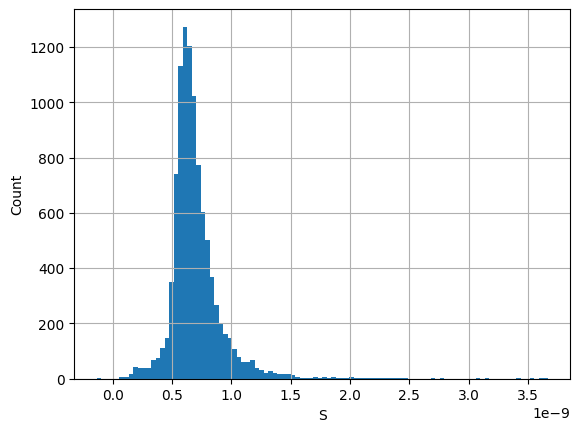

In [69]:
fig, ax = plt.subplots()
ax.hist(mip_S, bins=bin_num)
ax.set_xlabel("S")
ax.set_ylabel("Count")
ax.grid()
fig.savefig(f"{IMAGE_PATH}/S_hist.png")

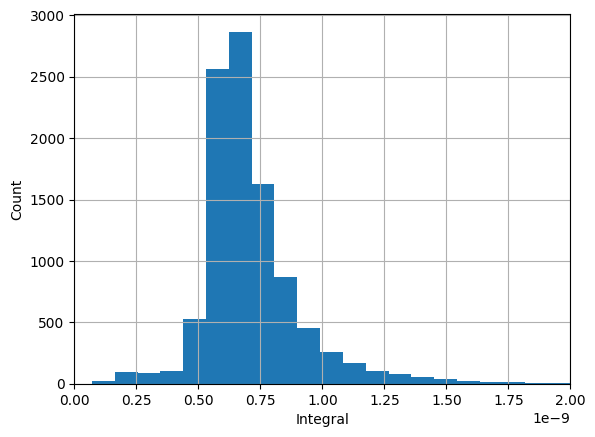

In [64]:
fig, ax = plt.subplots()
ax.hist(int_mip_S, bins=bin_num)
ax.set_xlabel("Integral")
ax.set_ylabel("Count")
ax.set_xlim(0e-9,2e-9)
ax.grid()
fig.savefig(f"{IMAGE_PATH}/integral_hist.png")

In [58]:
pl.DataFrame({
    "S": mip_S,
    "Integral_S": int_mip_S
}).write_csv(f"{IT_PATH}/S_integral.csv")